In [95]:
import pandas as pd
import geopandas as geopandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r2

In [96]:
# Importing dataset:
df = pd.read_json('preprocessed.json')


In [97]:

# Transform coordinates to geopandas
geometry = geopandas.points_from_xy(df.Lat, df.Lon)
geo_df = geopandas.GeoDataFrame(
    df[["Title", "Price", "Lon", "Lat"]], geometry=geometry
)
geo_df.head()


,Title,Price,Lon,Lat,geometry
0,"Apartament cu 2 camere, 80 m², Botanica, Chișinău",99900,28.843789,46.986127,POINT (46.98613 28.84379)
1,"Apartament cu 3 camere, 99 m², Centru, Chișinău",159900,28.850124,47.020729,POINT (47.02073 28.85012)
2,"O cameră, 17 m², Botanica, Chișinău",7900,28.949794,46.936900,POINT (46.93690 28.94979)
3,"Apartament cu 3 camere, 84 m², Durlești, Chișinău",65000,28.760488,47.011068,POINT (47.01107 28.76049)
4,"Apartament cu 2 camere, 67 m², Ciocana, Chișinău",72999,28.894026,47.037872,POINT (47.03787 28.89403)


In [98]:
from folium import plugins, folium
from branca.utilities import split_six

map = folium.Map(location=[47.036953, 28.833097, ], tiles="OpenStreetMap", zoom_start=7)

heat_data = [[point.xy[0][0], point.xy[1][0]] for point in geo_df.geometry]
print(heat_data[0])
plugins.HeatMap(heat_data, radius=12).add_to(map)

map

[46.986127, 28.8437895]


In [99]:
df.drop(columns=['Title',
                 'Region',
                 'Author',
                 'AuthorProfile',
                 'Description',
                 'UpdatedAt',
                 'Lon',
                 'Type',
                 'ID',
                 'Lat'], axis=1, inplace=True)


# OneHotEncoder for categorical features
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
OH_cols.index = df.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = df.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

In [100]:

# Drop missing values
df_final.dropna(inplace=True)

Text(0.5, 1.0, 'Price distribution by NrRooms')

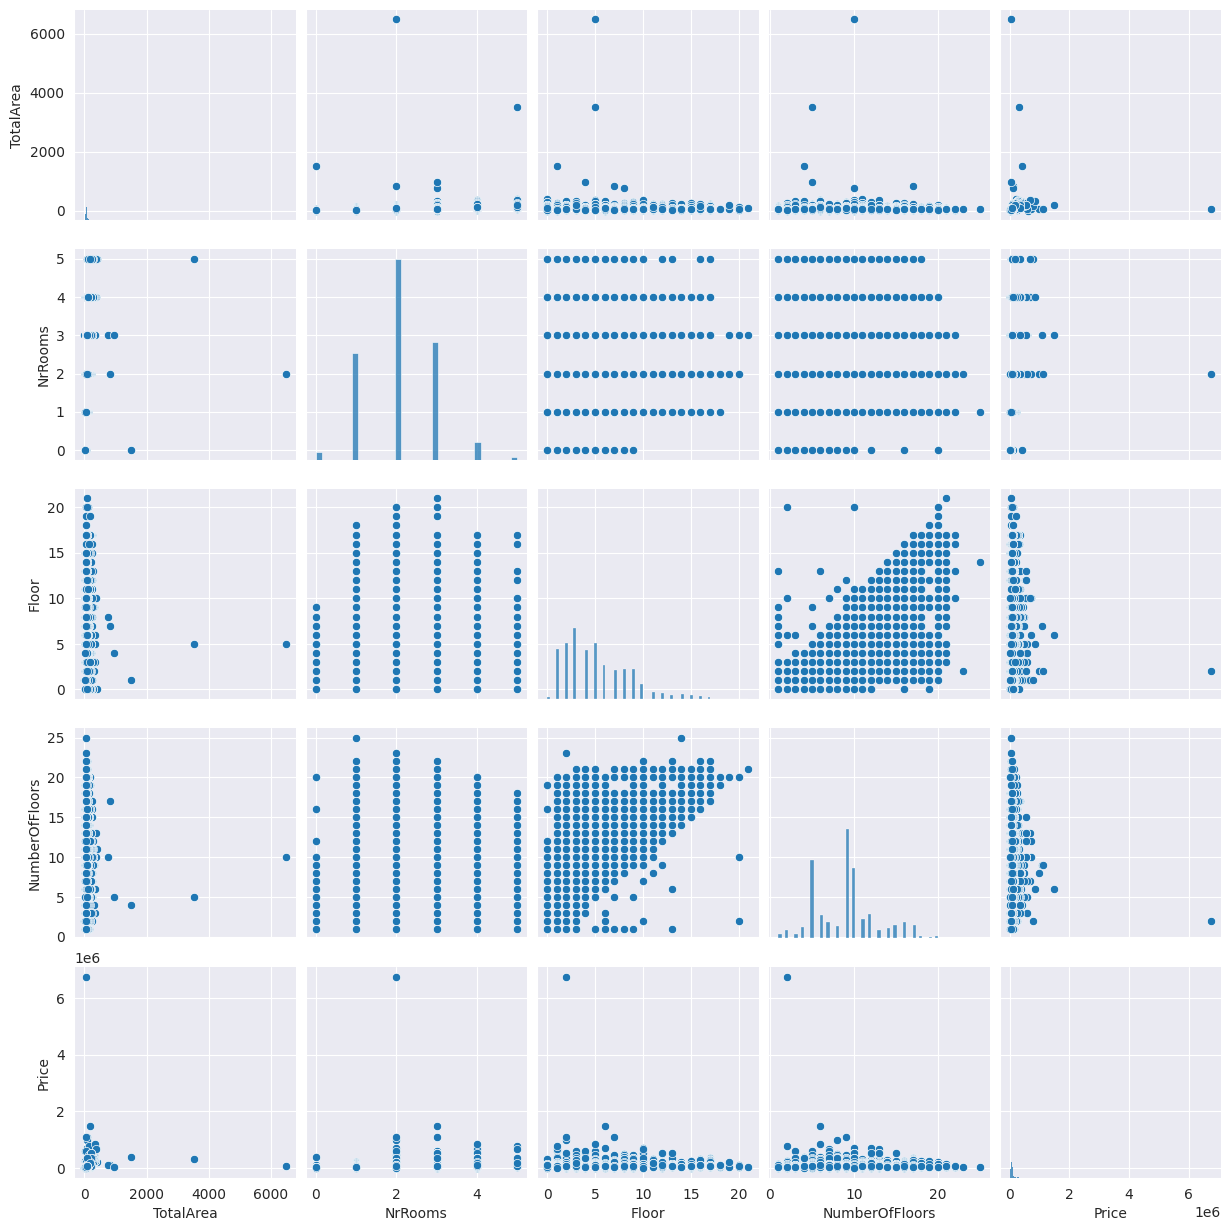

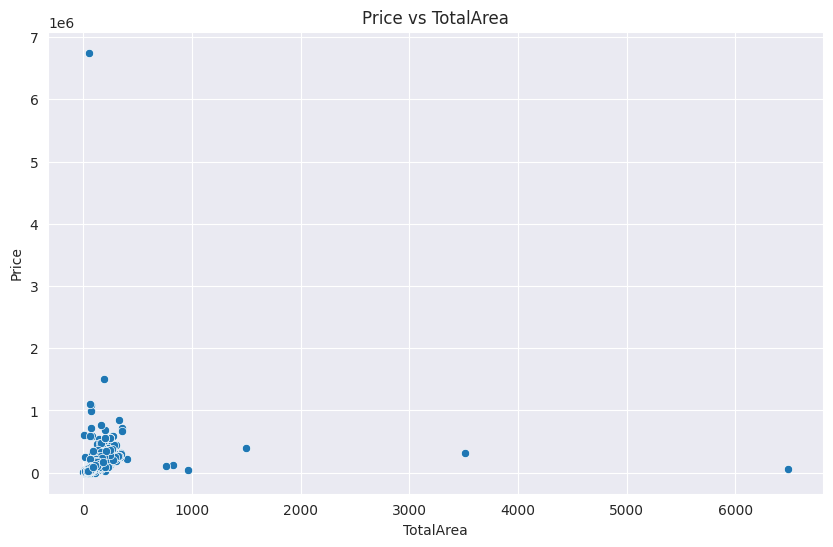

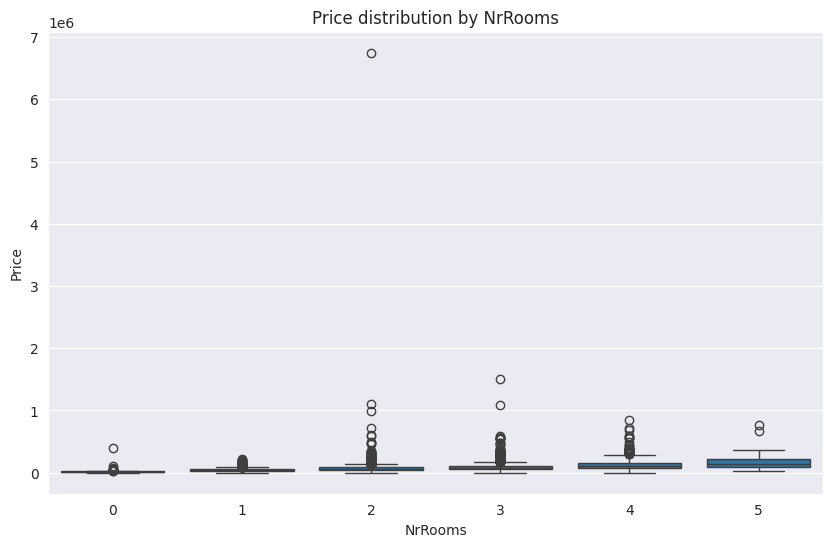

In [101]:
# Visualizations

# Pair plot for selected features
selected_features = ['TotalArea', 'NrRooms', 'Floor', 'NumberOfFloors', 'Price']
sns.pairplot(df_final[selected_features])

# Scatter plot for Price vs TotalArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalArea', y='Price', data=df_final)
plt.title('Price vs TotalArea')

# Box plot for Price distribution by NrRooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='NrRooms', y='Price', data=df_final)
plt.title('Price distribution by NrRooms')


In [112]:
def remove_outliers_iqr(dataframe, columns, multiplier=1.5):
    for column in columns:
        Q1 = dataframe[column].quantile(0.15)
        Q3 = dataframe[column].quantile(0.9)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

    return dataframe

Text(0.5, 1.0, 'Price distribution by NrRooms')

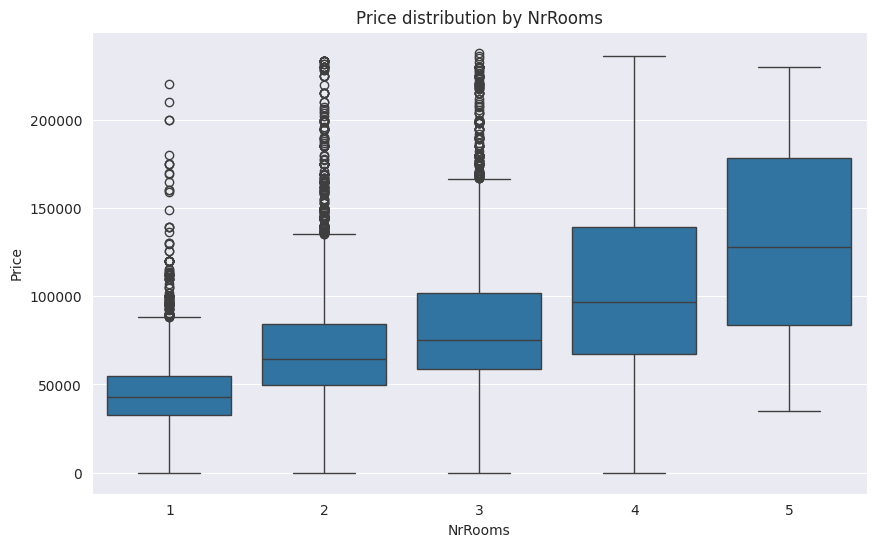

In [113]:
# Remove outliers based on 'Price' and 'NrRooms' columns
df_no_outliers = remove_outliers_iqr(df_final, columns=['Price', 'NrRooms'])
df_no_outliers = df_no_outliers[df_no_outliers['NrRooms'] != 0]
# Box plot for Price distribution by NrRooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='NrRooms', y='Price', data=df_no_outliers)
plt.title('Price distribution by NrRooms')



In [114]:
# Update the selected features for training and testing the models
X_var = df_no_outliers[['TotalArea', 'NrRooms', 'Balcony', 'Floor', 'NumberOfFloors',
                        'HousingType_Construcţii noi', 'HousingType_Secundar',
                        'Condition_Are nevoie de reparație', 'Condition_Construcție nefinisată',
                        'Condition_Dat în exploatare', 'Condition_Design individual',
                        'Condition_Euroreparație', 'Condition_Fără reparație',
                        'Condition_La alb', 'Condition_Reparație cosmetică']].values


y_var = df_no_outliers['Price'].values

# Split the dataset into training and testing sets again with the new feature
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size=0.2, random_state=0)


In [115]:
# Models

# 1. Linear Regression (OLS)
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

# 2. Ridge Regression
ridge = Ridge(alpha=0.0008)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# 3. Lasso Regression
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# 4. Bayesian Ridge Regression
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 5. ElasticNet Regression
en = ElasticNet(alpha=0.001)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

# 6. Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=2)
dtr.fit(X_train, y_train)
dtr_yhat = dtr.predict(X_test)



/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+12, tolerance: 1.774e+09
  model = cd_fast.enet_coordinate_descent(


In [116]:
# Evaluation

# 1. Explained Variance Score
models = [ols, ridge, lasso, bayesian, en, dtr]
model_names = ['OLS', 'Ridge', 'Lasso', 'Bayesian', 'ElasticNet', 'Decision Tree']
yhat_values = [ols_yhat, ridge_yhat, lasso_yhat, bayesian_yhat, en_yhat, dtr_yhat]

print('EXPLAINED VARIANCE SCORE:')
print('----------------------------------------------------')
for i, model in enumerate(models):
    print('{}: {}'.format(model_names[i], evs(y_test, yhat_values[i])))
    print('----------------------------------------------------')

# 2. R-squared
print('R-SQUARED:')
print('----------------------------------------------------')
for i, model in enumerate(models):
    print('{}: {}'.format(model_names[i], r2(y_test, yhat_values[i])))
    print('----------------------------------------------------')


EXPLAINED VARIANCE SCORE:
----------------------------------------------------
OLS: -4.228518304307024
----------------------------------------------------
Ridge: -4.2285141236695996
----------------------------------------------------
Lasso: -4.228515587616053
----------------------------------------------------
Bayesian: -4.220835362720139
----------------------------------------------------
ElasticNet: -4.2112879815469775
----------------------------------------------------
Decision Tree: 0.5631613824212947
----------------------------------------------------
R-SQUARED:
----------------------------------------------------
OLS: -4.229657026641314
----------------------------------------------------
Ridge: -4.2296528472851165
----------------------------------------------------
Lasso: -4.229654311052581
----------------------------------------------------
Bayesian: -4.221976749192888
----------------------------------------------------
ElasticNet: -4.212434882104145
------------------

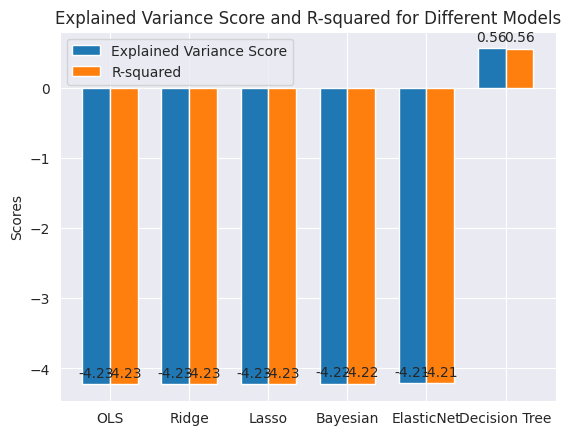

In [117]:

# Calculate Explained Variance Score and R-squared for each model
evs_values = [evs(y_test, yhat) for yhat in yhat_values]
r2_values = [r2(y_test, yhat) for yhat in yhat_values]

# Define the labels and values for the bar plot
labels = model_names
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, evs_values, width, label='Explained Variance Score')
rects2 = ax.bar(x + width/2, r2_values, width, label='R-squared')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Explained Variance Score and R-squared for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to auto-label bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()